# [Seismic] Data Encryption
This notebook paves the way for the 52 Things You Should Know About Geocomputing: [Seismic] Data Encryption chapter. Since we'll be encrypting and decrypting things in this notebook, we'll always use the same password:

> is_52_ytpeienncr_iTghsn_kye._oru_hTsi

Strong passwords are long passwords. Strength is added when the number of possible symbols increases, hence the punctuation and capitals in our password. Mixing up letters and words reduces the possibility of attack by [dictionary methods](http://web.cs.du.edu/~mitchell/forensics/information/pass_crack.html). Just start with a sentence like "*This is our 52 Things encryption key.*" Jumble up the letters and words from there. And I've used underscores in place of spaces here.

By the way, in the event you're storing your password on a computer (or a GitHub repo), never store it in *plaintext*. That is to say, don't just make a Google Document containing all your passwords. Anyone who gains access to the document (like this one) would now have your password (like the above). There's a process called hashing a password, which we'll now do using a simple Jupyter tool.

In [11]:
%matplotlib inline
from notebook.auth import passwd

In [6]:
passwd()

Enter password: ········
Verify password: ········


'sha1:9d1c863860bf:a012763baa888852196bca1308a613060775dced'

And that's it. This hash was built using SHA1, which is now trivially breakable. Python has some other awesome tools to perform hashing if you need realistically strong hashes ([with salt](https://en.wikipedia.org/wiki/Salt_(cryptography), etc.). Again, for the remainder of this notebook we'll use the above password in its plaintext form. I only mentioned hashing to get your wheels turning.

## Load seismic data into an array

The file we're loading is located in this repo under the `data` folder. I've already stripped a segy file down into and array of binary floats, so we don't require any special seismic manipulation tools. The array is of size 390 x 276.

**The seismic data used in this publication was obtained from [RMOTC and the U.S. Department of Energy](https://energy.gov/node/1012461/datasets.html) via the [SEG](http://wiki.seg.org/wiki/Teapot_dome_3D_survey).**

First we grab Numpy and set our size:

In [3]:
import numpy as np
ntr = 390
ns  = 276

Then we build an array

In [4]:
plain = np.zeros((ns, ntr))

and populate it with samples

In [5]:
import struct

In [6]:
with open('data/seis.bin', 'rb') as f:
    for i in range(ntr):
        for j in range(ns):
            plain[j,i] = struct.unpack('f', f.read(4))[0]

## How does image encryption do its thing?

In this section let's explore how we can encrypt an image. The toy algorithm we'll build here is based on parts of the [TEA (Tiny Encryption Algorithm)](http://citeseer.ist.psu.edu/viewdoc/download;jsessionid=C08E8409ADF484095568965A1EBF3E5E?doi=10.1.1.45.281&rep=rep1&type=pdf) cryptographic protocol. It is a symmetric encryption algorithm, meaning we'll use the same password (the one above) to both encrypt and decrypt the data.


**This code is not acceptable for real encryption. It is a demonstration toy. Do not use it to protect sensitive data!!!**


Additionally, even a good implementation of TEA isn't strong against modern cryptanalysis. But it is a really good demonstration of how modern cryptography works.

## Encrypt seismic data using a strong algorithm

Let's now use a free tool called [AEScrypt](https://www.aescrypt.com/) to encrypt the above seismic section. Below the -p flag specifies the password, where we've used the string from above. The -e flag specifies "encrypt" (instead of -d: "decrypt").

In [16]:
!aescrypt -p is_52_ytpeienncr_iTghsn_kye._oru_hTsi -e data/seis.bin

Now we'll load the enciphered data into an array for manipulation.

In [18]:
cipher = np.zeros((ns, ntr))

with open('data/seis.bin.aes', 'rb') as f:
    for i in range(ntr):
        for j in range(ns):
            cipher[j,i] = struct.unpack('f', f.read(4))[0]

## View plain data and enciphered data
Let's now view the *plainimage* data and the *cipherimage* data side-by-side. 

In [38]:
import matplotlib.pyplot as plt

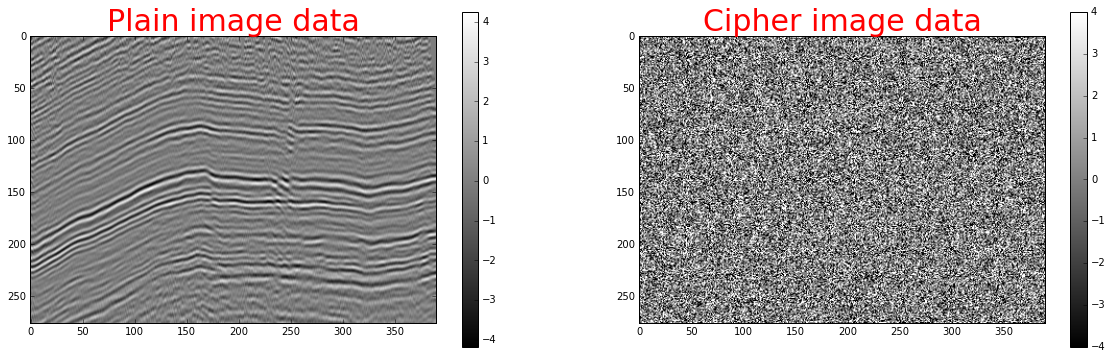

In [53]:
fig = plt.figure()

matplotlib.rcParams['figure.figsize'] = (20, 6)

a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(plain, cmap='gray')
a.set_title('Plain image data', fontsize=30, color='red')
plt.colorbar( orientation ='vertical')

a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(cipher, cmap='gray')
imgplot.set_clim(-4,4)
a.set_title('Cipher image data', fontsize=30, color='red')
plt.colorbar(ticks=range(-4, 5), orientation='vertical')

Obviously, you'd much rather an attacker have access to the cipherimage, not the plainimage.

The discerning reader will notice the grid in the cipher image. This is due to the blockwise operation of the AES algorithm. AES utilizes constant size blocks (128 bits), whereas other substitution-permutation cryptography algorithms can use blocks of varying size.